In [1]:
import helper
import numpy as np
import os
import matplotlib.pyplot as plt

/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:156: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:177: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [3]:
pop_size = 20
grn_size=22
dev_steps = 22
num_cells = 22
geneid=1
try_seedints = [69904,149796]

rule = 30

all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
    start_pattern = helper.seedID2string(s, num_cells)
    start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
    targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0], try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1], try_seedints[1])



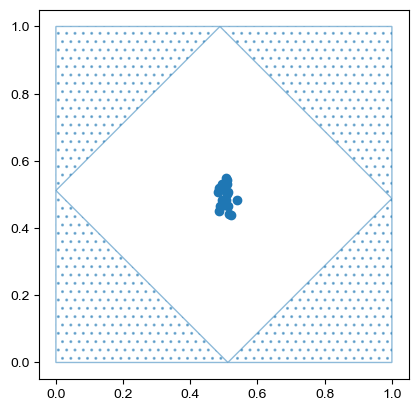

In [4]:
landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [5]:
root="results_testing_saving/"
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300,20_000,20_000]
rule = 30
rules = [f"{rule}-{rule}", rule, rule]
num_repeats = 2
pop_size = 1000

all_fits = []
for g in range(len(season_lens)):
    fits=[np.loadtxt(os.path.expanduser(root+f"stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
    fits = np.array(fits)
    num_gens = int(fits.shape[1]/2/pop_size)
    fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
    all_fits.append(fits)
all_fits=np.vstack(all_fits)
all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))
all_fits.shape

(3, 2, 2000, 2, 1000)

1999


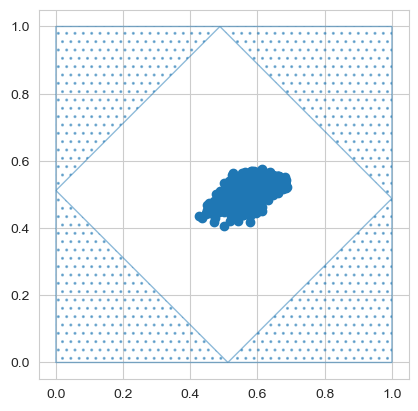

In [6]:
#NOTE: for static envs, fitnesses 1 is always the env they were evaluated on 
# (as opposed to fitnesses 2 being the relevant one when testing environment 1)

repid=1
a=list(range(2000))
check_freq=300
int_gens=a[check_freq-1::check_freq]

int_gens=[1999]

for i in int_gens:
    print(i)
    fitnesses1=all_fits[0][repid][i][0]
    fitnesses2=all_fits[0][repid][i][1]

    helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

#0.77429666 0.68433944 env 1
#0.67506982 0.73483343 env 2
#0.73658872 0.68701547

# GENERALISM

In [7]:
landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])
conz_BH, conz_BH_mean = helper.calc_conz_BH(all_fits, landmarks_list)

/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_26417/1706561750.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])


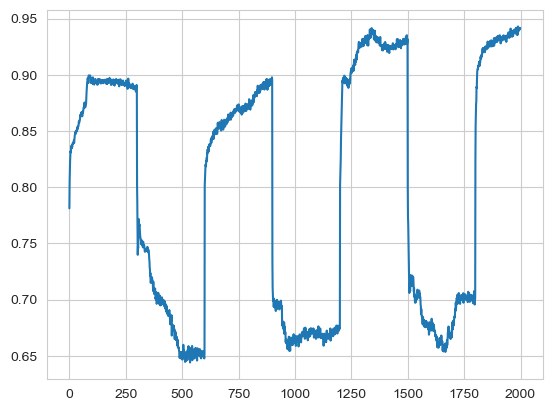

In [8]:
plt.plot(conz_BH_mean[0,0,:]) #NOTE: can do the 3 line plots with this list too!

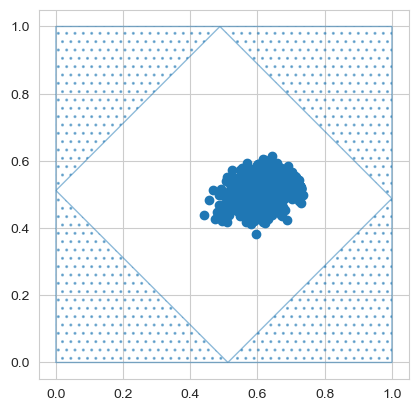

,x,y
0,1.000000,0.488142
1,0.488142,1.000000
2,0.744071,0.744071
3,0.872530,0.615613
4,0.615613,0.872530
5,0.000000,0.511858
6,0.511858,0.000000
7,0.255929,0.255929
8,0.755929,0.244071
9,0.244071,0.755929


In [9]:
fitnesses1=all_fits[0][0][np.argmax(conz_BH_mean[0,0,:])][0]
fitnesses2=all_fits[0][0][np.argmax(conz_BH_mean[0,0,:])][1]

helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [10]:
# Parameters
rule = 30
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300] #20_000,20_000]
rules = [f"{rule}-{rule}", rule, rule]
num_repeats = 2

all_grns = []
for g in range(len(season_lens)):
    grns=[np.loadtxt(os.path.expanduser(root+f"stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_best_grn.txt")) for i in range(num_repeats)]
    grns = np.array(grns)
    num_grns = int(grns.shape[1]/(grn_size+2)/grn_size)
    grns = grns.reshape(num_repeats,num_grns,grn_size+2,grn_size) #repeats, gens, weights1, weights2
    tmp=np.reshape(grns, (num_repeats,num_grns,(grn_size+2)*grn_size))
    all_grns.append(tmp)
all_grns=np.vstack(all_grns)
#all_grns = np.reshape(all_grns, (num_repeats * num_gens, grn_size+2, grn_size))
print(all_grns.shape)


(2, 2000, 528)


In [11]:
gens=list(range(num_gens))
season_len = 300
n_seasons = int(np.floor(num_gens/season_len))
chunked_gens = np.array([gens[i*300:(i+1)*300] for i in range(n_seasons)])
s1, s2 = chunked_gens[0::2], chunked_gens[1::2]
s1 = np.array([x for xs in s1 for x in xs])
s2 = np.array([x for xs in s2 for x in xs])

In [51]:
#NOTE: CAN EASILY MODIFY TO CHECK FOR EACH BEST GRN HOW GOOD IT WOULD DO GIVEN THE OTHER INPUT
#ONLY FOR VARIABLE EXPERIMENTS
best_fits = np.zeros((num_repeats,len(s1)+len(s2),2))
best_phenos = np.zeros((num_repeats,len(s1)+len(s2),dev_steps+1,num_cells))
#in season 1
for r in range(num_repeats):
    temp_grn = all_grns[r,s1,:]
    temp_grn = np.reshape(temp_grn, (len(s1), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s1, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=149796, seed_int_dev = 69904)
    best_fits[r, s1, 1] = fitnesses #compared to the alternative target
    print(phenos.shape)
    best_phenos[r, s1, :, :] = phenos
#in season 2
for r in range(num_repeats):
    temp_grn = all_grns[r,s2,:]
    temp_grn = np.reshape(temp_grn, (len(s2), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s2, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=69904, seed_int_dev = 149796)
    best_fits[r, s2, 1] = fitnesses #compared to the alternative target
    best_phenos[r, s2, :, :] = phenos
best_fits = np.array(best_fits) #num repeats, len(s1)+len(s2), fit1, fit2
best_fits2=best_fits[np.newaxis, :]
best_fits3=np.expand_dims(best_fits2, axis=-1) #same shape as all_fits but just for variable and 1 value per generation
best_fits3.shape

(900, 23, 22)
(900, 23, 22)


(1, 2, 1800, 2, 1)

In [52]:
best_conz_BH, _ = helper.calc_conz_BH(best_fits3, landmarks_list)
print(best_conz_BH.shape)
flat_index = np.argmax(best_conz_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, best_conz_BH.shape)
coordinates

(1, 2, 1800, 1)


(0, 0, 489, 0)

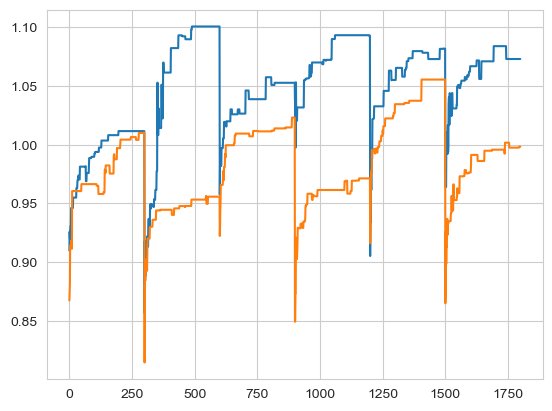

In [53]:
for i in range(num_repeats):
    plt.plot(best_conz_BH[0,i,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


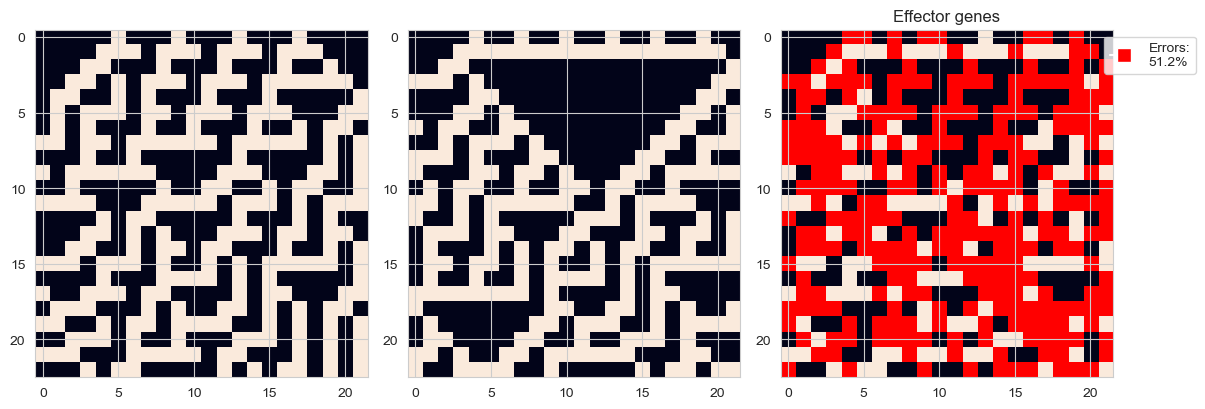

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
#Plot best phenotype
axs[0].imshow(all_targs[0])
#Plot target
axs[1].imshow(all_targs[1])
#Plot difference
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])

plt.tight_layout()
plt.show()

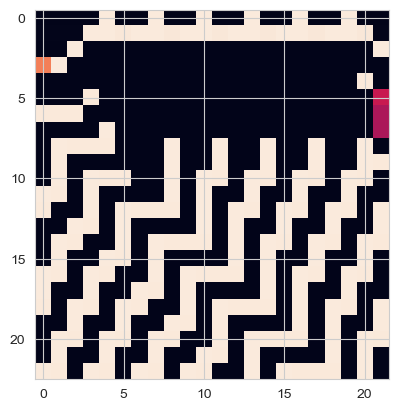

In [56]:
plt.imshow(best_phenos[coordinates[1], coordinates[2],:,:])

In [58]:
#NOTE: CAN EASILY MODIFY TO CHECK FOR EACH BEST GRN HOW GOOD IT WOULD DO GIVEN THE OTHER INPUT --> this is it
#ONLY FOR VARIABLE EXPERIMENTS
best_fits = np.zeros((num_repeats,len(s1)+len(s2),2))
best_phenos = np.zeros((num_repeats,len(s1)+len(s2),dev_steps+1,num_cells))
#in season 1
for r in range(num_repeats):
    temp_grn = all_grns[r,s1,:]
    temp_grn = np.reshape(temp_grn, (len(s1), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s1, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s1, 1] = fitnesses #compared to the alternative target
    print(phenos.shape)
    best_phenos[r, s1, :, :] = phenos
#in season 2
for r in range(num_repeats):
    temp_grn = all_grns[r,s2,:]
    temp_grn = np.reshape(temp_grn, (len(s2), grn_size+2, grn_size))
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=149796, seed_int_dev = 149796)
    best_fits[r, s2, 0] = fitnesses #compared to the current target
    _, phenos, fitnesses = helper.get_pop_TPF(temp_grn, len(temp_grn), num_cells, grn_size, dev_steps, geneid, rule, seed_int_target=69904, seed_int_dev = 69904)
    best_fits[r, s2, 1] = fitnesses #compared to the alternative target
    best_phenos[r, s2, :, :] = phenos
best_fits = np.array(best_fits) #num repeats, len(s1)+len(s2), fit1, fit2
best_fits2=best_fits[np.newaxis, :]
best_fits3=np.expand_dims(best_fits2, axis=-1) #same shape as all_fits but just for variable and 1 value per generation
best_fits3.shape

(900, 23, 22)
(900, 23, 22)


(1, 2, 1800, 2, 1)

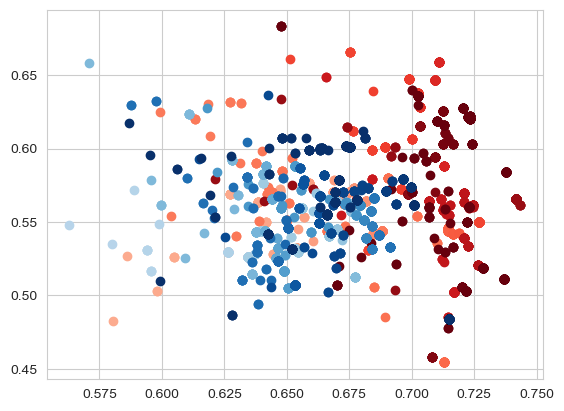

In [62]:
#Darker = newer, best GRN fitness in each generation, given that judging alternative environment happens with alternative input!
cmaps=["Reds", "Blues", "Greens"]

for r in range(num_repeats):
    color_map = plt.get_cmap(cmaps[r])
    for g in range(best_fits3.shape[2]):
        color = color_map(g / (num_gens - 1)+0.3)
        plt.scatter(best_fits3[0,r,g,0,0],best_fits3[0,r,g,1,0],color=color)

# Diversifying

In [ ]:
stds.append(np.std(both_fits[:,0,:],axis=1))

In [63]:
root="results_testing_saving/"
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300,20_000,20_000]
rule = 30
rules = [f"{rule}-{rule}", rule, rule]
num_repeats = 2
pop_size = 1000


all_edges = []
for g in range(len(season_lens)):
    edges=[np.loadtxt(os.path.expanduser(root+f"stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_edges.txt")) for i in range(num_repeats)]
    edges = np.array(edges).astype(int) 
    num_generations=int(edges.shape[1]/4/pop_size)
    print(edges.shape, num_generations)
    edges = edges.reshape(num_repeats, num_generations*pop_size, 2, 2)
    all_edges.append(edges)
all_edges=np.vstack(all_edges)
all_edges=np.reshape(all_edges, (3, num_repeats, num_generations*pop_size, 2, 2 ))
all_edges.shape

(2, 8000000) 2000
(2, 8000000) 2000
(2, 8000000) 2000


(3, 2, 2000000, 2, 2)

In [64]:
from tqdm import trange

kid_fits = np.zeros((3,num_repeats,num_generations-1,2, 100,10))
for e in range(3):
    for rep in range(num_repeats):
        for g in trange(num_generations-1): #last gen has kids but no fitnesses computed
            start = g*pop_size
            stop = g*pop_size + pop_size
            a = all_edges[e,rep,start:stop, :, :] #first generation, gen 0
            unique_first_positions, inverse_indices = np.unique(a[:, 0], axis=0, return_inverse=True)
            #print(unique_first_positions.shape) #100, parents
            #print(inverse_indices.shape) #1000, kids, including surviving parents
            b = np.array([a[:, 1][inverse_indices == i] for i in range(len(unique_first_positions))]) #for each parent, 10 kids, 2d id
            b = b[:,:,1] #only second id is interesting
            b_flattened = b.reshape(pop_size)
            b_fits = all_fits[e,rep,g+1,:,:][:,b_flattened] #have to be looking 1 gen down
            b_fits = b_fits.reshape(2, 100, 10) #the 2 fitness values, num parents, num kids
            #print(b_fits[1,3,5]) #fitness2 of the sixth kid of the fourth parent
            #print(all_fits[0,0,1,1,777]) #fitness2 of the 777th individual in the population in the second generation
            kid_fits[e,rep,g,:,:,:] = b_fits

100%|██████████| 1999/1999 [00:01<00:00, 1789.26it/s]


In [65]:
kid_fits.shape #experiment, rep, generation, 2 fits, 100 parents, 10 kids

(3, 2, 1999, 2, 100, 10)

In [67]:
div_BH, div_BH_mean = helper.calc_div_BH(kid_fits, landmarks)
div_BH.shape

(3, 2, 1999, 100)

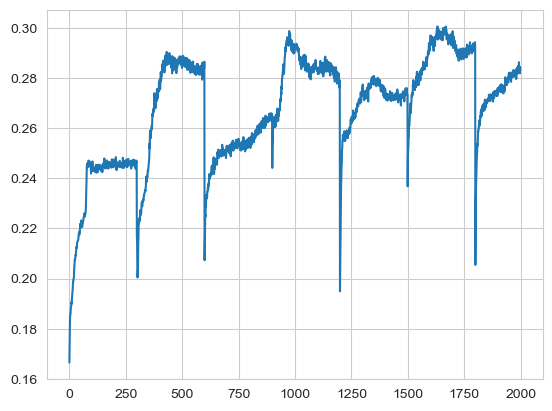

In [68]:
plt.plot(div_BH_mean[0,0,:]) #NOTE: can do the 3 line plots with this list too!

In [69]:
flat_index = np.argmax(div_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, div_BH.shape)
coordinates #experiment, rep, gen, parent

(1, 0, 1018, 39)

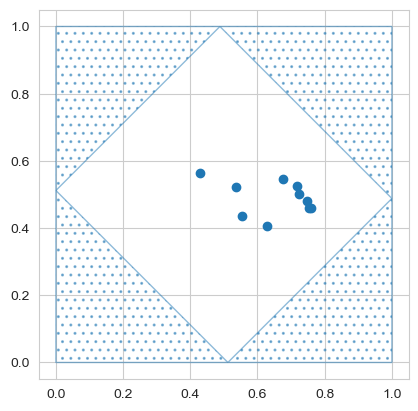

,x,y
0,1.000000,0.488142
1,0.488142,1.000000
2,0.744071,0.744071
3,0.872530,0.615613
4,0.615613,0.872530
5,0.000000,0.511858
6,0.511858,0.000000
7,0.255929,0.255929
8,0.755929,0.244071
9,0.244071,0.755929


In [73]:
fitnesses1 = kid_fits[coordinates[0],coordinates[1],coordinates[2],0,coordinates[3],:]
fitnesses2 = kid_fits[coordinates[0],coordinates[1],coordinates[2],1,coordinates[3],:]
helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [ ]:
flat_index = np.argmin(div_BH)
# Convert the flat index to coordinates in the original shape
coordinates = np.unravel_index(flat_index, div_BH.shape)
print(coordinates) #experiment, rep, gen, parent

for i in range(100):
    rand_coordinate = [np.random.choice([0,1,2]),np.random.choice([0,1]),np.random.choice(list(range(1800))),np.random.choice(list(range(100)))]
    coordinates = rand_coordinate
    fitnesses1 = kid_fits[coordinates[0],coordinates[1],coordinates[2],0,coordinates[3],:]
    fitnesses2 = kid_fits[coordinates[0],coordinates[1],coordinates[2],1,coordinates[3],:]
    helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)